# Food Item Classification

Submission Details - 
Name : Kiran Penumarthi - 
Email : kiranpenumarthi.bits@gmail.com

## Imports

Adding these 3 lines to ensure that any edits to libraries we make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
#@title
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to use the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163).

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate

## Getting Data

Using the chrome extension "CurlWget" grab the curl command to download the data set from the website https://www.vision.ee.ethz.ch/datasets_extra/food-101/

In [ ]:
# !wget --header="Host: data.vision.ee.ethz.ch" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-IN,en-US;q=0.9,en-GB;q=0.8,en;q=0.7" --header="Referer: https://zie8utvqque-colab.googleusercontent.com/v2/usercontent/8b5e8f2bbe60490e/outputframe.html?vrz=colab-20190208-085300-RC00_233068329" "https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz" -O "food-101.tar.gz" -c

In [11]:
!ls -lah

total 432K
drwxr-xr-x 4 jupyter jupyter 4.0K Feb 27 04:13 .
drwxr-xr-x 5 jupyter jupyter 4.0K Feb 21 07:45 ..
drwxr-xr-x 4 jupyter jupyter 4.0K Feb 13 05:39 food-101
-rw-r--r-- 1 jupyter jupyter 416K Feb 27 04:13 food-classification.ipynb
drwxr-xr-x 2 jupyter jupyter 4.0K Feb 13 05:14 .ipynb_checkpoints


In [12]:
# !tar xzf food-101.tar.gz

In [13]:
path = Path('food-101'); path.ls()

[PosixPath('food-101/README.txt'),
 PosixPath('food-101/images'),
 PosixPath('food-101/license_agreement.txt'),
 PosixPath('food-101/meta')]

In [14]:
img_path = path/'images'; img_path

PosixPath('food-101/images')

Checking a sample folder for the number of images

In [16]:
!ls -lh {path/'images/garlic_bread'} | wc -l  

1001


## Creating a DataBunch

Checking the contents of the meta folder

In [17]:
(path/'meta').ls()

[PosixPath('food-101/meta/train.json'),
 PosixPath('food-101/meta/test.txt'),
 PosixPath('food-101/meta/train.txt'),
 PosixPath('food-101/meta/test.json'),
 PosixPath('food-101/meta/labels.txt'),
 PosixPath('food-101/meta/classes.txt')]

In [20]:
!head {path}/meta/t*.txt

==> food-101/meta/test.txt <==
apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694
apple_pie/1047447
apple_pie/1068632
apple_pie/110043
apple_pie/1106961
apple_pie/1113017

==> food-101/meta/train.txt <==
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


The test.txt and train.txt files contain the file names of the train and the test set respectively

In [26]:
!wc -l {path}/meta/t*.txt

  25250 food-101/meta/test.txt
  75750 food-101/meta/train.txt
 101000 total


We load the contents of the test.txt into a list.

In [34]:
with open(path/'meta/test.txt') as f:
    test_list=list(f) 
train_list[:5]

['apple_pie/1005649\n',
 'apple_pie/1014775\n',
 'apple_pie/1026328\n',
 'apple_pie/1028787\n',
 'apple_pie/1043283\n']

We need to create a lamda function which will return true if the given PosixPath of an image is present in the test set. We use this function to split the data into validation (test) set and train set. So we format the test_list, so that it will contain the PosixPath for all the test images.

In [35]:
test_list = list(map(lambda x:x.strip(), test_list))
test_list = list(map(lambda x: Path("food-101/images/"+x+".jpg"), test_list))
test_list[:5]

[PosixPath('food-101/images/apple_pie/1011328.jpg'),
 PosixPath('food-101/images/apple_pie/101251.jpg'),
 PosixPath('food-101/images/apple_pie/1034399.jpg'),
 PosixPath('food-101/images/apple_pie/103801.jpg'),
 PosixPath('food-101/images/apple_pie/1038694.jpg')]

In [42]:
bs=64 #Lets start with a batch size of 64. If the GPU memory is insufficient, we can reduce it.
size=224 #Since we are going to use Resnet50 which is trained on size of 224, this is good default to start with.

We use the get_transforms util function to get the possible transformations that can be applied for the data augmentation of the images. These transforms are applied randomly with the specified probabilities for each imaegs and each epoch. https://docs.fast.ai/vision.transform.html#get_transforms

In [53]:
tfms=get_transforms(do_flip=True, #Allow flipping of images; a random flip is applied with probability 0.5
                    flip_vert=True, #The image can be flipped vertically or rotated of 90 degrees; This makes sense in the case of food images
                    max_rotate=90.0, #To allow rotation of the images; a random rotation between -max_rotate and max_rotate degrees is applied with probability p_affine
                    max_zoom=1.1, # To allow zooming of the images; a random zoom betweem 1. and max_zoom is applied with probability p_affine
                    max_lighting=0.2, #To allow changes in lighting; a random lightning and contrast change controlled by max_lighting is applied with probability p_lighting
                    max_warp=0.2, # Warping of the images; a random symmetric warp of magnitude between -max_warp and maw_warp is applied with probability p_affine
                    p_affine=0.75, #The probability that each affine transform and symmetric warp is applied
                    p_lighting=0.75) #The probability that each lighting transform is applied) 

Checking the transformations applied using the apply_tfms function

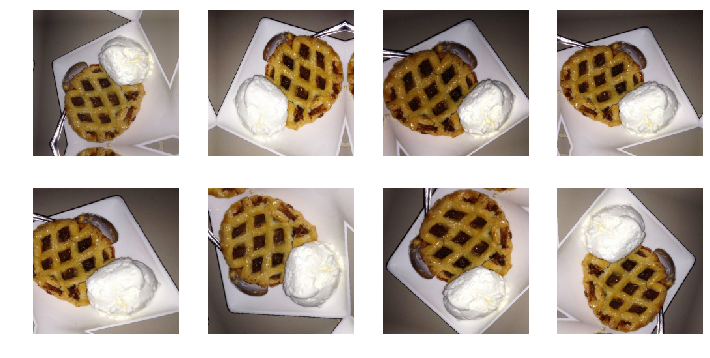

In [54]:
def get_ex(): return open_image(img_path/'apple_pie/1043283.jpg')
def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
plots_f(2, 4, 12, 6, size=224)

Now we create a DataBunch using the fastAi data_block API https://docs.fast.ai/data_block.html

In [ ]:
data = ((ImageItemList.from_folder(img_path) #Path to find the data -> The base folder and its subfolders
        .split_by_valid_func(lambda o: o in test_list) #Split the data into train/valid sets -> using the lambda
        .label_from_folder() #How to label? -> from the folder of the filenames
        .transform(tfms, size=size) #Data augmentation -> use tfms with the given size 
        .databunch(bs=bs)) #Create databunch with batch size of bs
        .normalize(imagenet_stats)) #Normalise the images using the same image_net stats used in the Resnet50

Checking a sample batch of the images and their lables

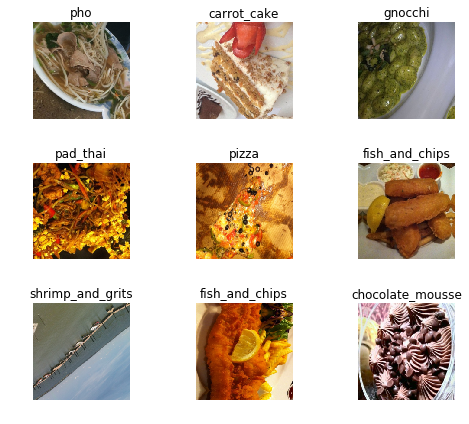

In [58]:
data.show_batch(rows=3, figsize=(7,6))

Checking the data classes

In [59]:
print(data.classes)
len(data.classes),data.c

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

(101, 101)

## Model

We create a CNN using trainsfer learning from resnet50 model which is trained on imageNet

In [60]:
learn = create_cnn(data, models.resnet50, metrics=[error_rate,accuracy]).to_fp16()

Using the fastai fit_one_cycle with default lr of 3e-3 without unfreezing the resnet50 layers

In [61]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy
1,2.028148,1.436590,0.390297,0.609703
2,1.599134,1.036804,0.285267,0.714733
3,1.370514,0.870910,0.240396,0.759604


Saviing and loading the learner, so that we can resume from this checkpoint later

In [63]:
learn.save('res-50-75')

In [73]:
learn.load('res-50-75')

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,carrot_cake,carrot_cake,carrot_cake,carrot_cake
Path: food-101/images;

Valid: LabelList (25250 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,carrot_cake,carrot_cake,carrot_cake,carrot_cake
Path: food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Batch

To confirm the accuracy on the test set.

In [74]:
learn.validate(learn.data.valid_dl, metrics=[accuracy])

[0.8709096, tensor(0.7596)]

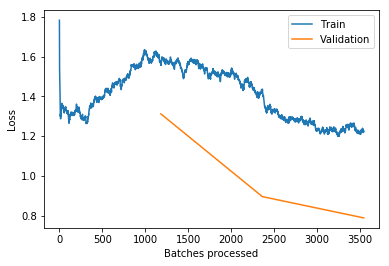

In [75]:
learn.recorder.plot_losses()

We got an accuracy of ~76%. The losses are decreasing and the training loss is higher than the validation loass. That means we are under fitting. So we can train for more epochs.

In [76]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy
1,1.624858,1.161134,0.317030,0.682970
2,1.402200,0.889421,0.242653,0.757347
3,1.218274,0.782265,0.216752,0.783248


So we reached an accuracy of 78%. Lets save the learner.

In [78]:
learn.save('res-50-78')

In [79]:
learn.load('res-50-78')

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,carrot_cake,carrot_cake,carrot_cake,carrot_cake
Path: food-101/images;

Valid: LabelList (25250 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,carrot_cake,carrot_cake,carrot_cake,carrot_cake
Path: food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Batch

Using the classification interpreter to check the images with top losses

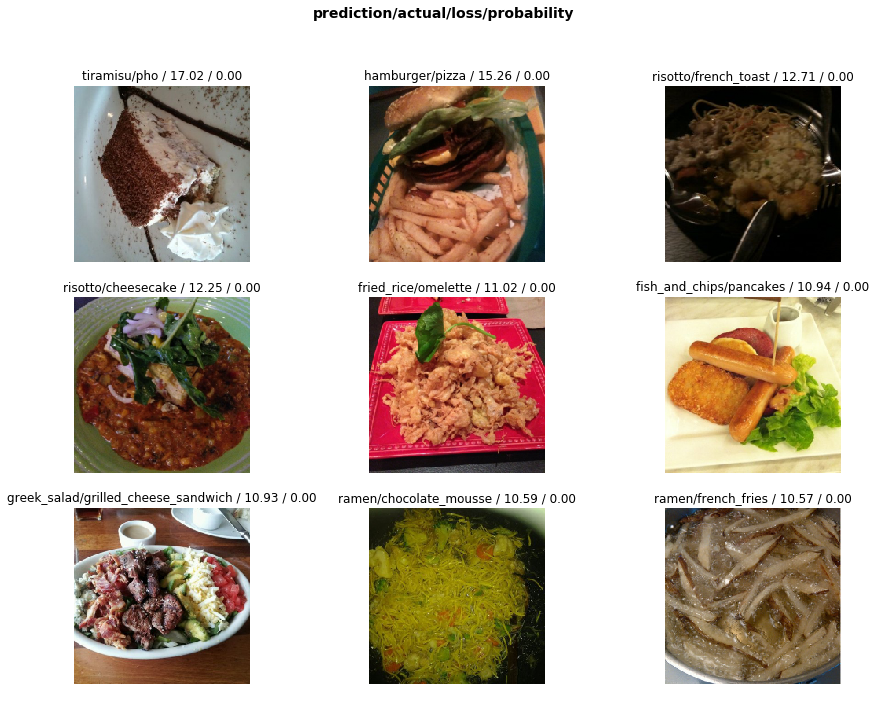

In [81]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

## Fine tuning

Till now we have frozen all the feature extraction layers in the resnet50 and were only training the classification layers. Now we can try to unfreeze all the layers and train all the layers. The initial layers are supposed to extract the basic features like edges, so these dont need to be trained as much as the middle or the end layers. So we use the differential learning rates for the layers which the fastai library provides

In [82]:
learn.unfreeze()

The fastai library provides a handy util to get a good learning rate to start with.

In [83]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-05


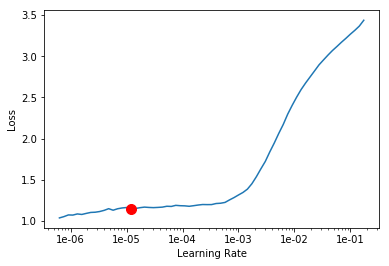

In [84]:
learn.recorder.plot()

In [85]:
learn.fit_one_cycle(3, max_lr=slice(1e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy
1,1.219937,0.796914,0.221030,0.778970
2,1.086918,0.687633,0.190931,0.809069
3,0.928794,0.627896,0.173901,0.826099


In [ ]:
learn.save("res-50-82.6")

In [95]:
learn.load("res-50-82.6")

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,carrot_cake,carrot_cake,carrot_cake,carrot_cake
Path: food-101/images;

Valid: LabelList (25250 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,carrot_cake,carrot_cake,carrot_cake,carrot_cake
Path: food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Batch

In [96]:
learn.validate(learn.data.valid_dl, metrics=[accuracy])

[0.62789625, tensor(0.8261)]

This gave us an accuracy of 82.61% for 3 epochs.

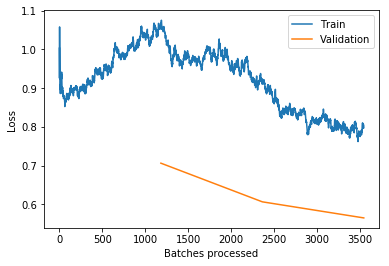

In [97]:
learn.recorder.plot_losses()

The losses are still decreasing, so we can fit for some more epochs.

In [98]:
learn.fit_one_cycle(3, max_lr=slice(1e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy
1,1.050345,0.690643,0.193743,0.806257
2,0.900876,0.607361,0.169149,0.830851
3,0.791257,0.563919,0.156832,0.843168


In [100]:
learn.save("res-50-84.3")

In [101]:
learn.load("res-50-84.3")

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,carrot_cake,carrot_cake,carrot_cake,carrot_cake
Path: food-101/images;

Valid: LabelList (25250 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,carrot_cake,carrot_cake,carrot_cake,carrot_cake
Path: food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Batch

In [103]:
learn.fit_one_cycle(3, max_lr=slice(1e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.807777,0.623345,0.175010,0.824990
2,0.743199,0.546228,0.153426,0.846574
3,0.624730,0.513209,0.144277,0.855723


In [104]:
learn.save("res-50-85.5")

In [105]:
learn.load("res-50-85.5")

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,carrot_cake,carrot_cake,carrot_cake,carrot_cake
Path: food-101/images;

Valid: LabelList (25250 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,carrot_cake,carrot_cake,carrot_cake,carrot_cake
Path: food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Batch

In [106]:
learn.validate(learn.data.valid_dl, metrics=[accuracy])

[0.5132086, tensor(0.8557)]

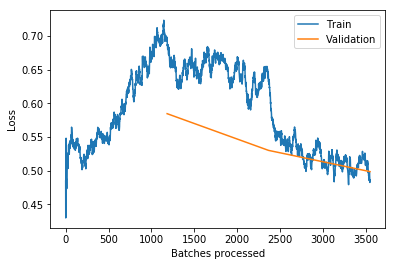

In [110]:
learn.recorder.plot_losses()

In [109]:
learn.fit_one_cycle(3, max_lr=slice(1e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.696552,0.584595,0.164079,0.835921
2,0.634204,0.529996,0.150455,0.849545
3,0.486161,0.498447,0.141584,0.858416


#### The training loss starts to get greater than the test loss. So its starting to overfit.
### The final accuracy we acheived is 85.84%

# Summary

#### Final accuracy acheived - 85.84%

## Parameters and augmentations used:

### Learning rate:
Primarily used the fastai library's LrFinder util to get the LR to start with.
1. Used a LR of 3e-3 for the model when all the feature extraction layers are frozen
2. Used a LR of 3e-4 for the classification layers when all the layers are unfrozen
3. Used a LR of 1e-5 for the initial feature extraction layers when all the layers are unfrozen (Lesser LR as these are alredy trained on image_net)

### Data augmentations:
Used the following augmentations:
1. Horizontal flips : as food images can be taken from any side
2. Vertical flips : as food images can be taken from top or bottom side
3. Rotations : Used a ratation of -90 to +90 as food images can be taken from any angle
4. Zoom : used a default zoom of 1.1
5. Lighting : used a default lighting of 0.2
6. Warping : used a default warping of 0.2

### Other optimisers and techniques used:
The following were used as defaults from the fastai library:
1. Adam optimiser
2. Dropout - For regularisation 
3. Batch normalisation - For regularisation
4. Momentum/RMS prop - For accelarating the convergence
5. fit_one_cycle - SGD with restarts and learning rate annealing 
6. Cross entropy loss over softmax - standard loss function for classification